In [8]:
import os

import numpy as np

from e3nn import o3
from e3nn.nn.models.gate_points_2102 import Convolution as ConvolutionGatePoints
from e3nn.math import soft_one_hot_linspace

import plotly.express as px

import torch
from torch_geometric.loader import DataLoader

from minimal_basis.dataset.dataset_reaction import ReactionDataset

from utils import (
    get_test_data_path,
    get_validation_data_path,
    get_train_data_path,
    read_inputs_yaml,
)

from ase import units as ase_units

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
inputs = read_inputs_yaml(os.path.join("input_files", "reaction_model.yaml"))

train_json_filename = inputs["debug_train_json"]
validate_json_filename = inputs["debug_validate_json"]

train_dataset = ReactionDataset( 
    root=get_train_data_path(),
    filename=train_json_filename,
    basis_filename=inputs["basis_file"],
)

validation_dataset = ReactionDataset(
    root=get_validation_data_path(),
    filename=validate_json_filename,
    basis_filename=inputs["basis_file"],
)

INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with data.
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with basis information.
INFO:minimal_basis.dataset.dataset_reaction:Parsing basis information.
Processing...
Done!
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with data.
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with basis information.
INFO:minimal_basis.dataset.dataset_reaction:Parsing basis information.
Processing...
Done!


In [4]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

Dimensions of the edge length embedding: torch.Size([13, 4])


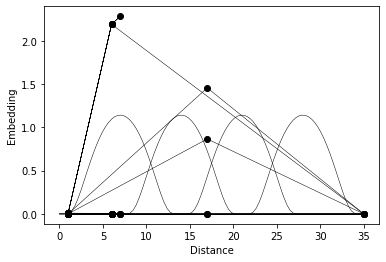

In [24]:
for idx, data in enumerate(train_loader):
    num_basis_spec = 4
    max_radius_spec = data.species_initial_state.max() 
    species_embedding = soft_one_hot_linspace(
        data.species_initial_state,
        start=0,
        end=max_radius_spec,
        number=num_basis_spec,
        basis="smooth_finite",
        cutoff=True,
    )
    species_embedding_cont = soft_one_hot_linspace(
        torch.linspace(0, max_radius_spec, 100),
        start=0,
        end=max_radius_spec,
        number=num_basis_spec,
        basis="smooth_finite",
        cutoff=True,
    )


    species_embedding = species_embedding.mul(num_basis_spec**0.5)

    print(f"Dimensions of the edge length embedding: {species_embedding.shape}")

    x_var = torch.linspace(0, max_radius_spec, 100)
    x_var_stack = torch.stack([x_var] * species_embedding.shape[0], dim=0)
    plt.plot( data.species_initial_state, species_embedding.detach().numpy(), 'o', color='k')
    plt.plot( data.species_initial_state, species_embedding.detach().numpy(), 'k', linewidth=0.5)
    plt.plot( torch.linspace(0, max_radius_spec, 100), species_embedding_cont.detach().numpy(), 'k', linewidth=0.5)
    # Plot a smooth version of the plot above
    plt.ylabel("Embedding")
    plt.xlabel("Distance")
    break

In [ ]:
all_mae_norms = []

for idx, data in enumerate(train_loader):

    interpolated_ts_coords = data.pos_interpolated_transition_state.detach().numpy()
    real_ts_coords = data.pos_transition_state.detach().numpy()
    difference_ts_coords = interpolated_ts_coords - real_ts_coords
    norm_difference_ts_coords = np.linalg.norm(difference_ts_coords, axis=1)

    # Mean absolute error
    mae = np.mean(norm_difference_ts_coords)
    all_mae_norms.append(mae)

    # Plot the real and interpolated TS structures
    # with two different colors on the same plot
    fig = px.scatter_3d(
        x=np.concatenate((real_ts_coords[:, 0], interpolated_ts_coords[:, 0])),
        y=np.concatenate((real_ts_coords[:, 1], interpolated_ts_coords[:, 1])),
        z=np.concatenate((real_ts_coords[:, 2], interpolated_ts_coords[:, 2])),
        color=np.concatenate((np.zeros(len(real_ts_coords)), np.ones(len(interpolated_ts_coords)))),
    )

    # Set the title of the plot as the mean absolute error
    fig.update_layout(title=f"MAE of structure prediction: {mae:.3f} Å")
    fig.write_html(f"plots/hamiltonian_model/interpolated_ts_{idx}_mae_{mae:.3f}.html")

# Plot a histogram of the MAE
fig = px.histogram(x=all_mae_norms, nbins=20, template="simple_white")
fig.update_layout(title="MAE structure prediction (Å)")
fig.update_xaxes(title_text="MAE (Å)")
fig.update_yaxes(title_text="Frequency")
fig.write_html("plots/hamiltonian_model/interpolated_ts_mae_histogram.html")
fig.show()

In [ ]:
for idx, data in enumerate(train_loader):
    # Compare the output of the model with the real coefficients
    output_model = model(data)
    output_real = data.x_transition_state

    # Take the difference between the real and model coefficients
    difference = output_model - output_real
    # Plot the difference as imshow
    fig = px.imshow(difference.detach().numpy())
    fig.show()
    break